# Linear SVM

# Problems Identification:
This project involves the implementation of efficient and effective LinearSVC on MNIST data set. The MNIST data comprises of digital images of several digits ranging from 0 to 9. Each image is 28 x 28 pixels. Thus, the data set has 10 levels of classes.

These are the needed packages:

In [1]:
import winsound
import matplotlib.pyplot as plt
plt.rcdefaults()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC, LinearSVC
from mnist import MNIST
from time import time
import matplotlib.pyplot as plt
plt.rcdefaults()
from IPython.display import display
from pylab import subplot
import pandas as pd
import numpy as np
import os
import random as rand

Load the dataset, having downloaded it from Yann. The train data set comprises of 60,000 samples and the test data set has 10,000 samples.

In [2]:
__mndata__ = MNIST(os.getcwd() +'\\image')
__train_image__, __train_label__ = __mndata__.load_training() #train & train_label
__test_image__, __test_label__ = __mndata__.load_testing() #test & test_label

The train and test images were reshaped to 784 dimension long, which translate to one feature for each pixel in the image.

### Visualization:
Visualizing a random 28 by 28 image.

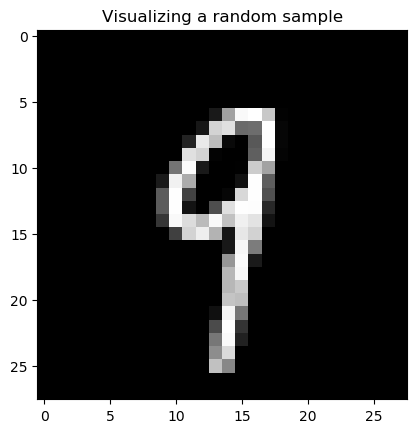

In [3]:
plt.imshow(np.reshape(__train_image__[rand.randint(1,1000)], [28,28]), cmap='Greys_r'); plt.title('Visualizing a random sample'); plt.show()

### Implementation functions:

In [28]:
class Utility:
    """This class warehouses the data and other general functions"""
    def __init__(self):
        self.train = np.asarray([np.reshape(x, (784)) for x in __train_image__]).astype(
            'float64')  # change train_image to numpy array #784 means 28 by 28 pixel
        self.train_label = np.asarray(__train_label__)
        self.test = np.asarray([np.reshape(x, (784)) for x in __test_image__]).astype(
            'float64')  # change test_image to numpy array
        self.test_label = np.asarray(__test_label__)
        self.n_class = list(range(10))  # class labels

    def confusionMatrix(actual, predict, classV=range(10), print_cfm=True, print_err_digit=True):
        cfm = pd.DataFrame(confusion_matrix(actual, predict))
        acc_all = round((sum(np.diagonal(cfm)) / len(predict)) * 100, 4)
        acc_digit = []
        for i in classV:
            acc_digit.append(round(cfm.iloc[i, i] / sum(cfm.iloc[i, :]), 4) * 100)

        tab_error = pd.DataFrame(columns=['digit', 'Accuracy per digit in %'])
        tab_error['digit'] = classV
        tab_error['Accuracy per digit in %'] = acc_digit

        if print_cfm:
            print('Testing Confusion Matrix: Actual vs. Prediction')
            display(cfm)

        if print_err_digit:
            print('% Accuracy per digit')
            display(tab_error)
            print('\nThe overall testing accuracy is {}%'.format(acc_all))

        return cfm, tab_error, acc_all

    def mutiplePlot(xValue, yValues, legend, title, xLabel, yLabel, color):
        plt.subplots(figsize=(10, 5))
        for i in range(len(yValues)):
            plt.semilogx(xValue, yValues[i], '-gD', label=legend[i], color=color[i])
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.grid(True)
        plt.legend()
        plt.title(title)
        plt.show()

    def plot_(xValues, yValue, xlabel, ylabel, title, semilogx=False, semilogy=False):
        yValue = np.round(yValue, 4)
        if semilogx:
            plt.semilogx(xValues, yValue, '-gD', color='black')
        elif semilogy:
            plt.semilogy(xValues, yValue, '-gD', color='black')
        else:
            plt.plot(xValues, yValue, '-gD', color='black')
            # ax.set_xticks(xValues, xValues)

        ax = subplot(111)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.show()
        
    def images_plot(imageData):
        classes = ["class=0", "class=1", "class=2","class=3", "class=4","class=5","class=6","class=7","class=8", "class=9"]
        num_classes = len(classes)
        plt.subplots(figsize=(15, 2))
        for y, cls in enumerate(classes):
            plt_idx = y + 1
            plt.subplot(1, num_classes, plt_idx)
            plt.imshow(imageData[y].reshape((28, 28)))
            plt.axis("off")
            plt.title(cls)

        plt.tight_layout()
        plt.show()

    def sound_notifier():
        winsound.Beep(1000, 10000)

# End of Class Utility

class SVM_Models:
    '''This class warehouses functions for various models'''
    def __init__(self, train, train_lb, test, test_lb, k_fold_cv=None, live=True):
        '''
        :param train: X train
        :param train_lb: y train
        :param test: X test
        :param test_lb: y test
        :param k_fold_cv: number of folds for cross validation
        '''
        self.train = train
        self.train_lb = train_lb
        self.test = test
        self.test_lb = test_lb
        self.kfold = k_fold_cv
        self.live = live

    def linear_svc(self, costs, penalty='l2'):
        #http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
        time_ = time()
        self.df = pd.DataFrame(index=range(len(costs)), columns=['cost', 'train_acc', 'test_acc'])
        self.coef, self.test_pred, self.time_model = [], [], []
        self.time_pred, self.time_all = [], 0
        for i, c in enumerate(costs):
            self.df['cost'][i] = c
            model = LinearSVC(dual=False, C=c, penalty=penalty)
            st_tim = time()
            model_fit = model.fit(self.train, self.train_lb)
            self.time_model.append(time() - st_tim)
            self.coef.append(model_fit.coef_)
            self.df['train_acc'][i] = model_fit.score(self.train, self.train_lb)
            st_tim = time()
            pred = model_fit.predict(self.test)
            self.time_pred.append(time() - st_tim)
            self.test_pred.append(pred)
            self.df['test_acc'][i] = accuracy_score(self.test_lb, pred)
            
        self.time_all = time() - time_
        if not self.live:
            Utility.sound_notifier()

# How the multi-class classification is different for SVC and LinearSVC?

SVC in Sklearn implement the “one-against-one” methodology for multi-class classification [2]. 
Hence given n classes, n*(n - 1)/2 classifiers would be modeled. Thus, in the case of MNIST dataset, there will be a total of 45 classifiers.

"To provide a consistent interface with other classifiers, the decision_function_shape option allows aggregating the results of the “one-against-one” classifiers to a decision function of shape (n_samples, n_classes)" [2].

For LinearSVC, performs “one-vs-the-rest” multi-class classification. Hence, a total of n classifier, However, only one classifier will be trained if there are two classes [2]. Thus, in this project 10 classifiers are modeled for LinearSVC.

# Linear SVC - L2 Penalty

### (i) Plot of overall training and testing accuracy versus input parameter C 

In [4]:
util = Utility()
costs = np.logspace(-4, 4, 9)

In [5]:
model_1 = SVM_Models(util.train, util.train_label, util.test, util.test_label, live=False)
model_1.linear_svc(costs)

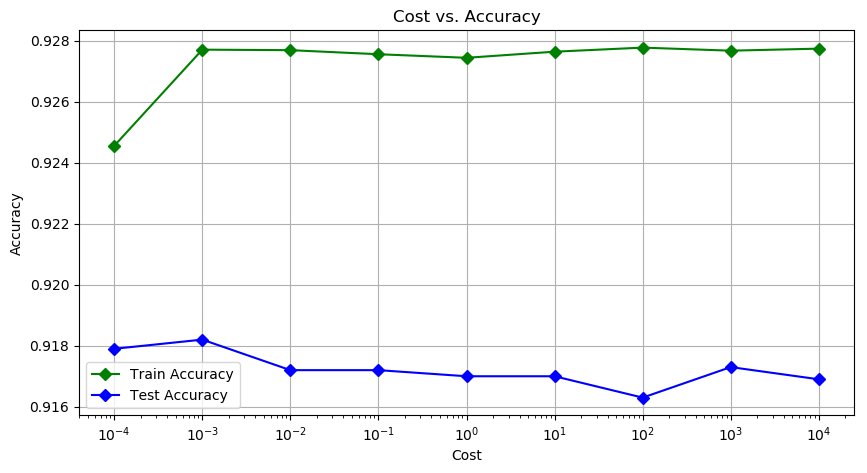

In [6]:
accuracys_1 = [model_1.df['train_acc'], model_1.df['test_acc']]
Utility.mutiplePlot(costs, accuracys_1, ['Train Accuracy', 'Test Accuracy'], 'Cost vs. Accuracy', 'Cost', 'Accuracy', ['green', 'blue'])

In [19]:
display(model_1.df)

,cost,train_acc,test_acc
0,0.0001,0.92455,0.9179
1,0.001,0.9277,0.9182
2,0.01,0.927683,0.9172
3,0.1,0.92755,0.9172
4,1,0.927433,0.917
5,10,0.927633,0.917
6,100,0.927767,0.9163
7,1000,0.927667,0.9173
8,10000,0.927733,0.9169


A small value (more room for misclassification) of cost tends to underfit the model which leads to high bias and low variance. At C=0.0001, the training and testing accuracy are 0.92455 and 0.9179 respectively, this seems to be underfitting with low variance and high bias.

Conversely, at a constant cost, large cost (complex model - no room for misclassification) overfit the model resulting in low bias and high variance. At C=100, the training and testing accuracy are 0.927767 and 0.9163 respectively, this shows overfitting with high variance and low bias.

The best value of cost should give a balanced trade-off between variance and bias. From the plot and table above, it is can be seen that C=0.001 provides a balanced tradeoff between bias and variance, this gives a train and test accuracy of 0.9277 and 0.9182 respectively.

### (ii) Images of the 10 coef_ outputs for C=0.001

In [25]:
best_model_1 = model_1.coef[1]

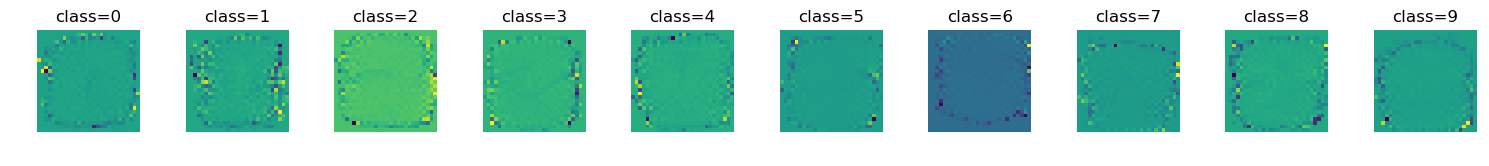

In [29]:
Utility.images_plot(best_model_1)

The images above are the model vectors learned by the SVM. The coef_ are the weights assigned to the features [1]. The color intensity of the images differ, class 6 seem to be dimmer, while class 2 has the lightest background color. Thus, it seems that the weight attributed to class 6 is more compared to the weight attributed to 2.

Although the images seem to be distinct, there isn't a clear pattern compared to the images of the conditional probabilities in Naive Bayes and that of the weights in logistic regression.

# Linear SVC - L1 Penalty

### (iii) Plot of overall training and testing accuracy versus input parameter C and images of coef_ outputs

In [8]:
model_L1 = SVM_Models(util.train, util.train_label, util.test, util.test_label, live=False)
model_L1.linear_svc(costs, penalty='l1')

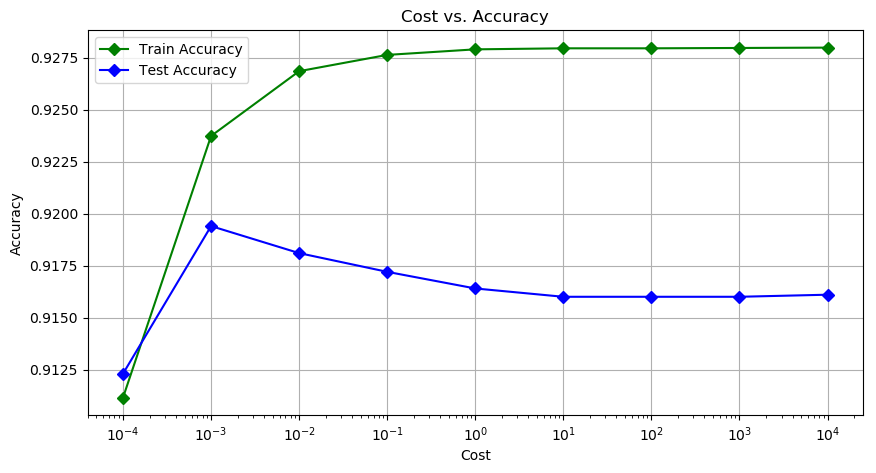

In [9]:
accuracys_L1 = [model_L1.df['train_acc'], model_L1.df['test_acc']]
Utility.mutiplePlot(costs, accuracys_L1, ['Train Accuracy', 'Test Accuracy'], 'Cost vs. Accuracy', 'Cost', 'Accuracy', ['green', 'blue'])

In [10]:
display(model_L1.df)

,cost,train_acc,test_acc
0,0.0001,0.91115,0.9123
1,0.001,0.923733,0.9194
2,0.01,0.92685,0.9181
3,0.1,0.927633,0.9172
4,1,0.9279,0.9164
5,10,0.92795,0.916
6,100,0.92795,0.916
7,1000,0.927967,0.916
8,10000,0.927983,0.9161


A small value (more room for misclassification) of cost tends to underfit the model which leads to high bias and low variance. 

At C=0.0001, the training and testing accuracy are 0.923733 and 0.9123 respectively, this seems to be underfitting with low variance and high bias.

Conversely, at a constant cost, large cost (complex model - no room for misclassification) overfit the model resulting in low bias and high variance. At C=10000, the training and testing accuracy are 0.927983 and 0.9161 respectively, this shows overfitting with high variance and low bias.

The best value of cost should give a balanced trade-off between variance and bias. From the plot and table above, it is can be seen that C=0.001 provides a balanced tradeoff between bias and variance, this gives a train and test accuracy of 0.923733 and 0.9194 respectively.

#### Images of the 10 coef_ outputs for C=0.001 (L1 Penalty)

In [34]:
best_model_L1 = model_L1.coef[1]

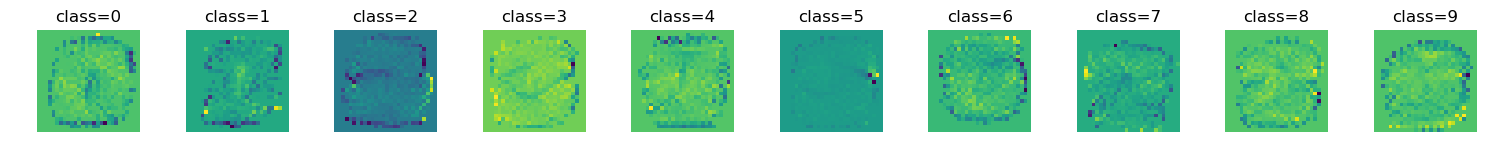

In [35]:
Utility.images_plot(best_model_L1)

This is really fascinating, the classifier actually modeled the image that corresponds to the class. In this case, an image of class 2 seems to be dimmer, while that of class 3 is faint. It appears that the weight attributed to class is higher compared to other classes.

These are partly similar to the images of the conditional probabilities in Naive Bayes, but Naive Bayes also model the image of the actual label of the original images. They are also similar to the images of the weights in logistic regression, though, some of the images do not exactly look like the class.

### References:

[1]. http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

[2]. http://scikit-learn.org/stable/modules/svm.html

[3]. http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC